In [2]:
# IMPORTS

# PyTorch - neural network framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# data manipulation and analysis
import pandas as pd
import numpy as np
import random

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# warnings
import warnings
warnings.filterwarnings('ignore')

# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

#### 1. Data Loading

In [3]:
# loading the train and validation datasets
X_train = pd.read_csv('../Data/breast_cancer_trainset.csv').drop(columns=['diagnosis'])
y_train = pd.read_csv('../Data/breast_cancer_trainset.csv')['diagnosis']

X_val = pd.read_csv('../Data/breast_cancer_valset.csv').drop(columns=['diagnosis'])
y_val = pd.read_csv('../Data/breast_cancer_valset.csv')['diagnosis']

# data dimensions
print("Data Split Dimensions:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

# target distribution
print("-"*60)
print("Target Distribution:")
print(f"Train: {(y_train==0).sum()/len(y_train)*100:.1f}% Benign (0), {(y_train==1).sum()/len(y_train)*100:.1f}% Malignant (1)")
print(f"Validation: {(y_val==0).sum()/len(y_val)*100:.1f}% Benign (0), {(y_val==1).sum()/len(y_val)*100:.1f}% Malignant (1)")
print("-"*60)

Data Split Dimensions:
X_train: (398, 30)
y_train: (398,)
X_val: (57, 30)
y_val: (57,)
------------------------------------------------------------
Target Distribution:
Train: 62.6% Benign (0), 37.4% Malignant (1)
Validation: 63.2% Benign (0), 36.8% Malignant (1)
------------------------------------------------------------


#### 2. Preprocessing

Since sklearn pipelines don't work directly with PyTorch, we implement preprocessing carefully to avoid data leakage. For baseline model, we fit scaler on training data only. Later, for cross-validation, we'll fit a NEW scaler for each fold.

In [5]:
# Initialize StandardScaler (neural networks - they need normalized features)
scaler = StandardScaler()

# Fit scaler ONLY on training data, then transform both train and validation
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train.values)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val.values)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders for batching
batch_size = 32  # Default batch size for baseline
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Preprocessing Complete:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Feature shape: {X_train_scaled.shape[1]} features")

Preprocessing Complete:
Training samples: 398
Validation samples: 57
Batch size: 32
Number of training batches: 13
Feature shape: 30 features


#### 3. Neutral Network Architecture

We define a flexible feedforward neural network architecture using PyTorch's nn.Module class. The network consists of an input layer (30 features), two hidden layers with ReLU activation functions, and an output layer for binary classification (2 classes: benign or malignant). Each hidden layer includes batch normalization to stabilize training and dropout for regularization to prevent overfitting. The architecture is parameterized, allowing us to easily tune hyperparameters like hidden layer sizes (default: 64 and 32 neurons) and dropout rate (default: 0.3) during the optimization phase. Batch normalization normalizes the inputs to each layer, which helps the model train faster and more reliably, while dropout randomly deactivates a proportion of neurons during training to encourage the network to learn robust features rather than memorizing the training data. This architecture balances model complexity with generalization capability, making it suitable for our relatively small dataset of 398 training samples.

In [6]:
# defining the Neural Network Architecture
class BreastCancerNet(nn.Module):
    def __init__(self, input_size=30, hidden_size1=64, hidden_size2=32, dropout_rate=0.3, num_classes=2):
        """
        Nerual Network Architecture for Breast Cancer Classification
        Args:
            input_size: number of input features (30 for breast cancer dataset)
            hidden_size1: number of neurons in the first hidden layer
            hidden_size2: number of neurons in the second hidden layer
            dropout_rate: dropout probability for regularization
            num_classes: number of output classes (2 for binary classification)
        """
        super(BreastCancerNet, self).__init__()

        # first hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        # second hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        # output layer
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        """
        Forward pass through the network
        """
        # layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # output layer
        x = self.fc3(x)
        return x

# displaying the model architecture
baseline_model = BreastCancerNet()
print("Model Architecture:")
print(baseline_model)
print(f"Total parameters: {sum(p.numel() for p in baseline_model.parameters())}")
        

Model Architecture:
BreastCancerNet(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
Total parameters: 4322


#### 4. Training and Evaluation Functions

We define reusable training and evaluation functions that will be used throughout our experimentation. The training function performs forward propagation, calculates loss using CrossEntropyLoss (which works for both binary and multi-class classification by treating our problem as a 2-class classification task), performs backpropagation, and updates model weights using the Adam optimizer. It tracks the average loss per epoch to monitor training progress. The evaluation function puts the model in evaluation mode (disabling dropout and batch normalization updates), makes predictions on the validation set without computing gradients (for efficiency), and calculates comprehensive performance metrics including accuracy, precision, recall, F1-score, and ROC-AUC. These functions encapsulate the core training loop logic, making our code modular and reusable for both baseline model training and later cross-validation experiments.

In [ ]:
# Training Function
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    """
    Training loop for the neural network
    Args:
        model: Neural Network model to train
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimization algorithm
        num_epochs: Number of training epochs

    Returns:
        train_losses: list of average training loss per epoch
    """

    train_losses = []

    # looping over the number of epochs
    for epoch in range(num_epochs):
        model.train() # setting model to training mode (enables dropout and batch normalization)
        running_loss = 0.0

        # iterating through the batches
        for inputs, labels in train_loader:
            # zeroing the parameter gradients
            optimizer.zero_grad()
            # forward pass: compute predictions
            outputs = model(inputs)
            # compute loss
            loss = criterion(outputs, labels)
            # backward pass: compute gradients
            loss.backward()
            # update weights
            optimizer.step()

            # accumulating the loss
            running_loss += loss.item()

        # calculating the average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # printing progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return train_losses

# Evaluation Function
def evaluate_model(model, val_loader, val_tensor_X, val_tensor_y):
    """
    Evaluate model performance on validation set
    Args:
        model: Trained neural network model
        val_loader: DataLoader for validation data
        val_tensor_X: Validation features tensor
        val_tensor_y: Validation labels tensor

    Returns:
        Dictionary containing all evaluation metrics
    """
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm training)
    
    # Make predictions without computing gradients (saves memory and computation)
    with torch.no_grad():
        # Get predictions
        outputs = model(val_tensor_X)
        _, predicted = torch.max(outputs, 1)  # Get class with highest score
        
        # Get prediction probabilities for ROC-AUC
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1 (malignant)
        
        # Convert to numpy for sklearn metrics
        y_true = val_tensor_y.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_prob = probabilities.cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    # Return all metrics as dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

print("Training and evaluation functions defined successfully!")

Training and evaluation functions defined successfully!


#### 5. Baseline Model Training

We train a baseline neural network model with default hyperparameters to establish a benchmark for comparison. This baseline uses 50 training epochs, a learning rate of 0.001, and the Adam optimizer. The purpose of the baseline is to understand the model's performance before hyperparameter tuning, which will help us quantify improvements from optimization. We track the training loss over epochs to monitor convergence, then evaluate the model on the validation set using multiple metrics including accuracy, precision, recall, F1-score, and ROC-AUC. Since this is a medical diagnosis task where missing malignant cases (false negatives) is more costly than false alarms (false positives), we pay particular attention to recall performance.

In [9]:
# initializing baseline model
baseline_model = BreastCancerNet(
    input_size=X_train.shape[1],
    hidden_size1=64,
    hidden_size2=32,
    dropout_rate=0.3,
    num_classes=2
)

# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

# training parameters
num_epochs = 50

print("Baseline Model Training")
print("=" * 60)
print(f"Epochs: {num_epochs}")
print(f"Learning Rate: 0.001")
print(f"Optimizer: Adam")
print(f"Batch Size: 32")
print("=" * 60)
print()

# training the model
baseline_train_losses = train_model(
    model=baseline_model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

print()
print("Training Complete")

Baseline Model Training
Epochs: 50
Learning Rate: 0.001
Optimizer: Adam
Batch Size: 32

Epoch 5/50, Loss: 0.2043
Epoch 10/50, Loss: 0.1274
Epoch 15/50, Loss: 0.1253
Epoch 20/50, Loss: 0.0975
Epoch 25/50, Loss: 0.0774
Epoch 30/50, Loss: 0.0899
Epoch 35/50, Loss: 0.0558
Epoch 40/50, Loss: 0.0646
Epoch 45/50, Loss: 0.0936
Epoch 50/50, Loss: 0.0603

Training Complete


#### 6. Baseline Model Evaluation

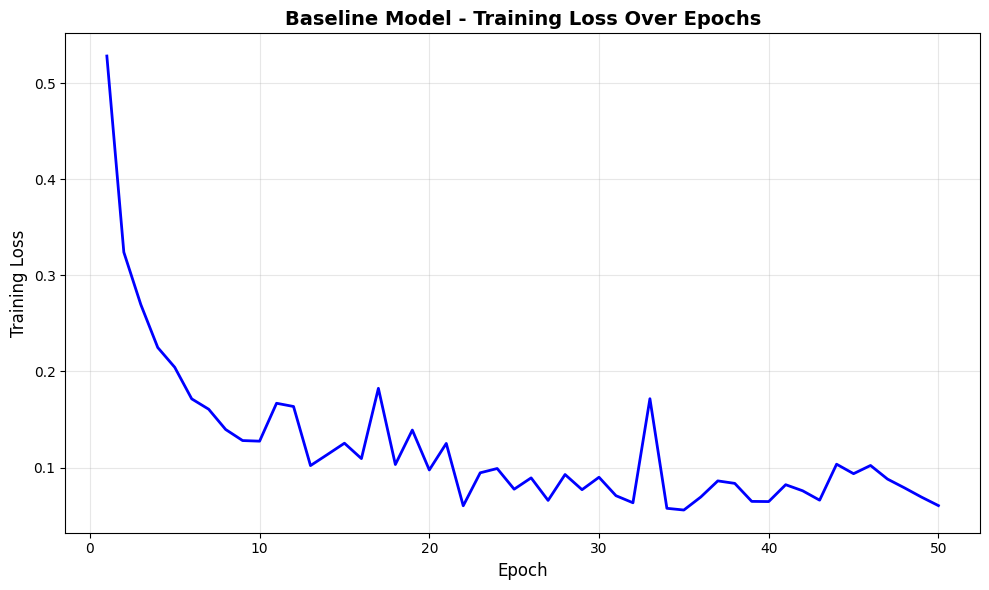

BASELINE MODEL - VALIDATION SET PERFORMANCE
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00        36
   Malignant       1.00      1.00      1.00        21

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



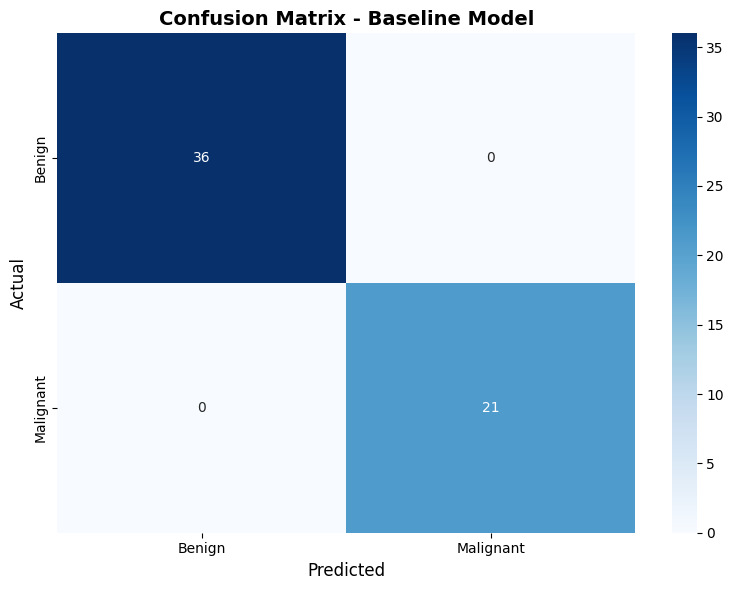

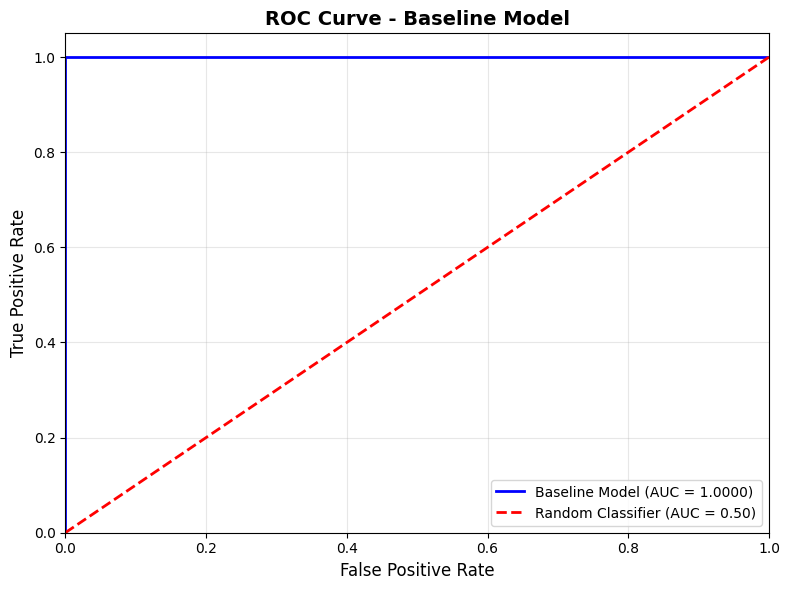

In [10]:
# Plot Training Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(baseline_train_losses) + 1), baseline_train_losses, 'b-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Baseline Model - Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate baseline model on validation set
baseline_results = evaluate_model(baseline_model, val_loader, X_val_tensor, y_val_tensor)

# Print evaluation metrics
print("=" * 60)
print("BASELINE MODEL - VALIDATION SET PERFORMANCE")
print("=" * 60)
print(f"Accuracy:  {baseline_results['accuracy']:.4f}")
print(f"Precision: {baseline_results['precision']:.4f}")
print(f"Recall:    {baseline_results['recall']:.4f}")
print(f"F1-Score:  {baseline_results['f1']:.4f}")
print(f"ROC-AUC:   {baseline_results['roc_auc']:.4f}")
print("=" * 60)
print()

# Classification Report
print("Classification Report:")
print(classification_report(baseline_results['y_true'], baseline_results['y_pred'], 
                          target_names=['Benign', 'Malignant']))

# Confusion Matrix
cm_baseline = confusion_matrix(baseline_results['y_true'], baseline_results['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Baseline Model', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# ROC Curve
fpr_baseline, tpr_baseline, _ = roc_curve(baseline_results['y_true'], baseline_results['y_prob'])
plt.figure(figsize=(8, 6))
plt.plot(fpr_baseline, tpr_baseline, 'b-', linewidth=2, 
         label=f"Baseline Model (AUC = {baseline_results['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Baseline Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 7. Cross-Validation with Hyperparameter Tuning

To complete the preprocessing-in-pipeline and find optimal hyperparameters, we implement manual k-fold cross-validation with StratifiedKFold (5 folds) to maintain class distribution across folds. Critically, for each fold, we fit a NEW StandardScaler on the training portion only and then transform both train and validation portions, preventing data leakage while embedding preprocessing within the cross-validation loop. We perform a grid search over multiple hyperparameters including learning rate, batch size, hidden layer architectures, dropout rates, and number of epochs. For each hyperparameter combination, we train the model on each fold and track the average validation recall score (our primary metric for medical diagnosis to minimize false negatives). This computationally intensive process tests numerous configurations to identify the best-performing hyperparameters, which we'll use to train our final optimized model. The entire process ensures robust model selection while maintaining proper data handling practices.

In [14]:
# Cross-Validation with Hyperparameter Tuning

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'hidden_size1': [64, 128, 256],
    'hidden_size2': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.5],
    'num_epochs': [50, 100]
}

print("=" * 70)
print("HYPERPARAMETER TUNING WITH CROSS-VALIDATION")
print("=" * 70)
print(f"Parameters to tune:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: 486")
print(f"K-folds: 5")
print(f"Total training runs: 486 x 5 = 2430")
print("=" * 70)
print()

# Initialize StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results
cv_results = []

# Convert data to numpy for CV splitting
X_train_np = X_train.values
y_train_np = y_train.values

# Generate all parameter combinations
from itertools import product
param_combinations = list(product(
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['hidden_size1'],
    param_grid['hidden_size2'],
    param_grid['dropout_rate'],
    param_grid['num_epochs']
))

# Grid search with cross-validation
for idx, (lr, batch_size, h1, h2, dropout, epochs) in enumerate(param_combinations, 1):
    print(f"[{idx}/{len(param_combinations)}] Testing: lr={lr}, batch={batch_size}, "
          f"h1={h1}, h2={h2}, dropout={dropout}, epochs={epochs}")
    
    fold_recalls = []
    
    # K-Fold Cross-Validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_np, y_train_np), 1):
        # Split data for this fold
        X_fold_train, X_fold_val = X_train_np[train_idx], X_train_np[val_idx]
        y_fold_train, y_fold_val = y_train_np[train_idx], y_train_np[val_idx]
        
        # CRITICAL: Fit NEW scaler on THIS fold's training data only
        fold_scaler = StandardScaler()
        X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train)
        X_fold_val_scaled = fold_scaler.transform(X_fold_val)
        
        # Convert to tensors
        X_fold_train_tensor = torch.FloatTensor(X_fold_train_scaled)
        y_fold_train_tensor = torch.LongTensor(y_fold_train)
        X_fold_val_tensor = torch.FloatTensor(X_fold_val_scaled)
        y_fold_val_tensor = torch.LongTensor(y_fold_val)
        
        # Create DataLoader for this fold
        fold_train_dataset = TensorDataset(X_fold_train_tensor, y_fold_train_tensor)
        fold_train_loader = DataLoader(fold_train_dataset, batch_size=batch_size, shuffle=True)
        
        # Initialize model
        model = BreastCancerNet(
            input_size=30,
            hidden_size1=h1,
            hidden_size2=h2,
            dropout_rate=dropout,
            num_classes=2
        )
        
        # Define optimizer and loss
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # Train model
        model.train()
        for epoch in range(epochs):
            for inputs, labels in fold_train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # Evaluate on fold validation set
        model.eval()
        with torch.no_grad():
            outputs = model(X_fold_val_tensor)
            _, predicted = torch.max(outputs, 1)
            fold_recall = recall_score(y_fold_val_tensor.numpy(), predicted.numpy())
            fold_recalls.append(fold_recall)
    
    # Calculate average recall across folds
    avg_recall = np.mean(fold_recalls)
    std_recall = np.std(fold_recalls)
    
    print(f"Average Recall: {avg_recall:.4f}")
    print()
    
    # Store results
    cv_results.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'hidden_size1': h1,
        'hidden_size2': h2,
        'dropout_rate': dropout,
        'num_epochs': epochs,
        'avg_recall': avg_recall,
        'std_recall': std_recall
    })

# Find best hyperparameters
best_result = max(cv_results, key=lambda x: x['avg_recall'])

print("=" * 70)
print("BEST HYPERPARAMETERS FROM CROSS-VALIDATION")
print("=" * 70)
print(f"Learning Rate:   {best_result['learning_rate']}")
print(f"Batch Size:      {best_result['batch_size']}")
print(f"Hidden Layer 1:  {best_result['hidden_size1']}")
print(f"Hidden Layer 2:  {best_result['hidden_size2']}")
print(f"Dropout Rate:    {best_result['dropout_rate']}")
print(f"Epochs:          {best_result['num_epochs']}")
print(f"\nBest CV Recall: {best_result['avg_recall']:.4f}")
print("=" * 70)

HYPERPARAMETER TUNING WITH CROSS-VALIDATION
Parameters to tune:
  learning_rate: [0.001, 0.01, 0.1]
  batch_size: [16, 32, 64]
  hidden_size1: [64, 128, 256]
  hidden_size2: [32, 64, 128]
  dropout_rate: [0.2, 0.3, 0.5]
  num_epochs: [50, 100]

Total combinations: 486
K-folds: 5
Total training runs: 486 x 5 = 2430

[1/486] Testing: lr=0.001, batch=16, h1=64, h2=32, dropout=0.2, epochs=50
  → Average Recall: 0.9331 (±0.0296)

[2/486] Testing: lr=0.001, batch=16, h1=64, h2=32, dropout=0.2, epochs=100
  → Average Recall: 0.9260 (±0.0394)

[3/486] Testing: lr=0.001, batch=16, h1=64, h2=32, dropout=0.3, epochs=50
  → Average Recall: 0.9333 (±0.0632)

[4/486] Testing: lr=0.001, batch=16, h1=64, h2=32, dropout=0.3, epochs=100
  → Average Recall: 0.9326 (±0.0372)

[5/486] Testing: lr=0.001, batch=16, h1=64, h2=32, dropout=0.5, epochs=50
  → Average Recall: 0.9531 (±0.0339)

[6/486] Testing: lr=0.001, batch=16, h1=64, h2=32, dropout=0.5, epochs=100
  → Average Recall: 0.9326 (±0.0427)

[7/486] 

#### 8. Final Tuned Model Training

Using the best hyperparameters identified through cross-validation, we now train the final optimized model on the complete training dataset. This final model uses the hyperparameter combination that achieved the highest average recall score during cross-validation. We apply the same preprocessing pipeline (StandardScaler fitted on training data only) to maintain consistency and prevent data leakage. The model is trained for the optimal number of epochs with the best learning rate, batch size, network architecture, and dropout rate discovered during hyperparameter tuning. After training, we evaluate the tuned model on the validation set and compare its performance against the baseline model to quantify the improvement from hyperparameter optimization. This comparison demonstrates whether the tuning process successfully enhanced model performance, particularly for recall which is our primary metric for minimizing false negatives in cancer diagnosis.

In [15]:
# Train final model with best hyperparameters

# Recreate preprocessing with best batch size
best_batch_size = best_result['batch_size']
train_loader_tuned = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader_tuned = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# Initialize tuned model with best hyperparameters
tuned_model = BreastCancerNet(
    input_size=30,
    hidden_size1=best_result['hidden_size1'],
    hidden_size2=best_result['hidden_size2'],
    dropout_rate=best_result['dropout_rate'],
    num_classes=2
)

# Define optimizer and loss with best learning rate
criterion_tuned = nn.CrossEntropyLoss()
optimizer_tuned = optim.Adam(tuned_model.parameters(), lr=best_result['learning_rate'])

print("=" * 60)
print("FINAL TUNED MODEL TRAINING")
print("=" * 60)
print("Training with best hyperparameters:")
print(f"  Learning Rate:   {best_result['learning_rate']}")
print(f"  Batch Size:      {best_result['batch_size']}")
print(f"  Hidden Layer 1:  {best_result['hidden_size1']}")
print(f"  Hidden Layer 2:  {best_result['hidden_size2']}")
print(f"  Dropout Rate:    {best_result['dropout_rate']}")
print(f"  Epochs:          {best_result['num_epochs']}")
print("=" * 60)
print()

# Train the tuned model
tuned_train_losses = train_model(
    model=tuned_model,
    train_loader=train_loader_tuned,
    criterion=criterion_tuned,
    optimizer=optimizer_tuned,
    num_epochs=best_result['num_epochs']
)

FINAL TUNED MODEL TRAINING
Training with best hyperparameters:
  Learning Rate:   0.1
  Batch Size:      16
  Hidden Layer 1:  64
  Hidden Layer 2:  32
  Dropout Rate:    0.2
  Epochs:          50

Epoch 5/50, Loss: 0.2466
Epoch 10/50, Loss: 0.1798
Epoch 15/50, Loss: 0.1471
Epoch 20/50, Loss: 0.1356
Epoch 25/50, Loss: 0.1562
Epoch 30/50, Loss: 0.1711
Epoch 35/50, Loss: 0.0869
Epoch 40/50, Loss: 0.1846
Epoch 45/50, Loss: 0.1484
Epoch 50/50, Loss: 0.1942


#### 9. Evaluation/Comparison of Tuned Model

MODEL COMPARISON: BASELINE VS TUNED
Metric        Baseline    Tuned      Change
------------------------------------------------------------
Accuracy      1.0000      0.9649     -0.0351
Precision     1.0000      0.9130     -0.0870
Recall        1.0000      1.0000     +0.0000
F1-Score      1.0000      0.9545     -0.0455
ROC-AUC       1.0000      0.9987     -0.0013

Tuned Model Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.94      0.97        36
   Malignant       0.91      1.00      0.95        21

    accuracy                           0.96        57
   macro avg       0.96      0.97      0.96        57
weighted avg       0.97      0.96      0.97        57



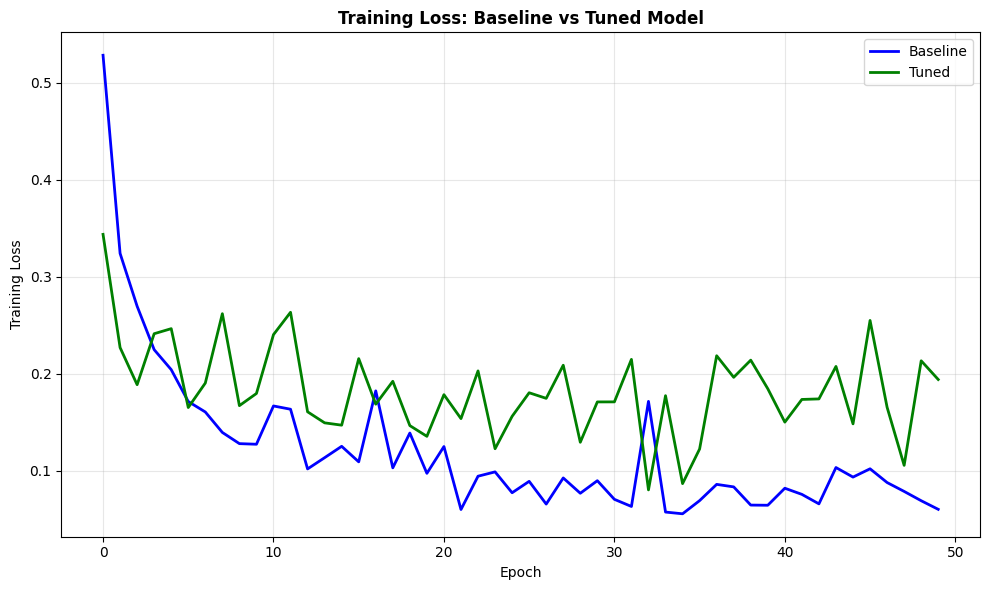

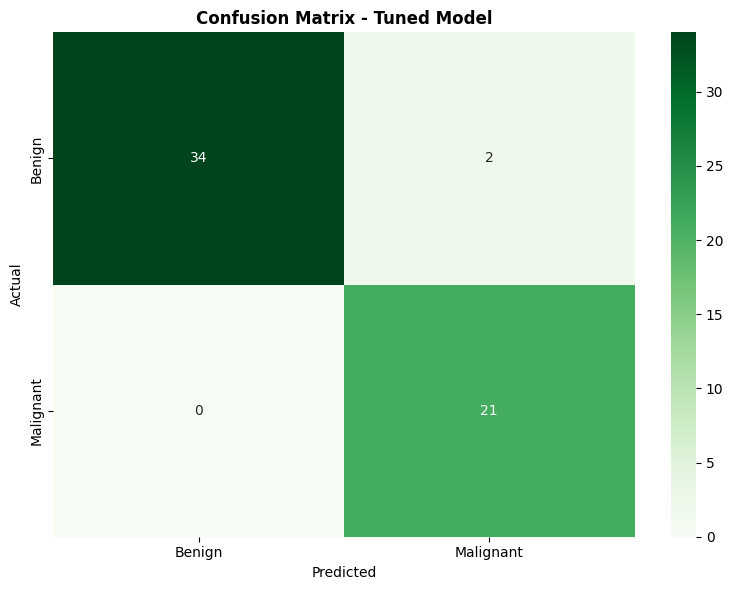

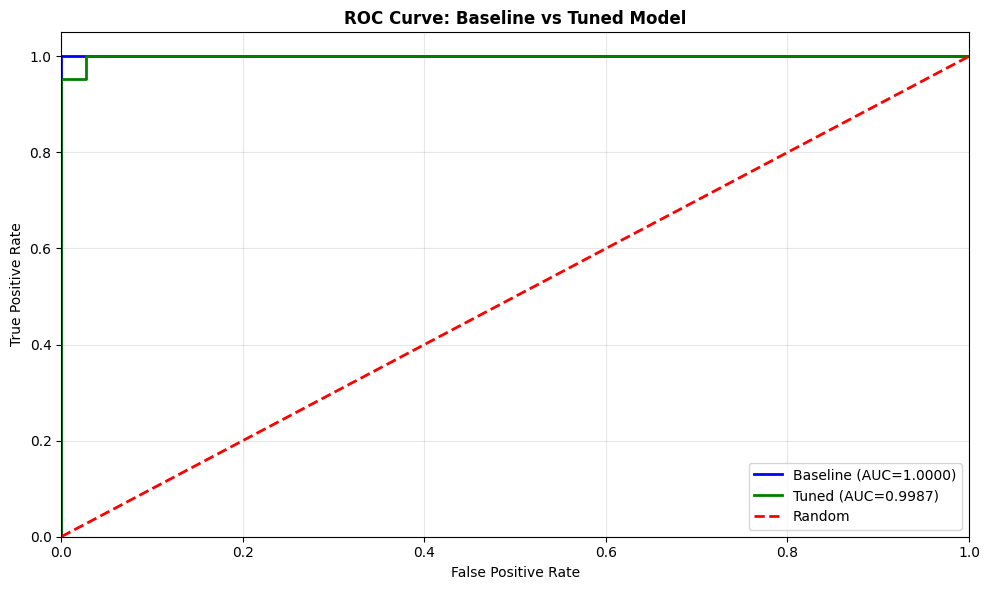

In [16]:
# Evaluate tuned model on validation set
tuned_results = evaluate_model(tuned_model, val_loader_tuned, X_val_tensor, y_val_tensor)

# Print comparison
print("=" * 60)
print("MODEL COMPARISON: BASELINE VS TUNED")
print("=" * 60)
print(f"Metric        Baseline    Tuned      Change")
print("-" * 60)
print(f"Accuracy      {baseline_results['accuracy']:.4f}      {tuned_results['accuracy']:.4f}     {(tuned_results['accuracy']-baseline_results['accuracy']):+.4f}")
print(f"Precision     {baseline_results['precision']:.4f}      {tuned_results['precision']:.4f}     {(tuned_results['precision']-baseline_results['precision']):+.4f}")
print(f"Recall        {baseline_results['recall']:.4f}      {tuned_results['recall']:.4f}     {(tuned_results['recall']-baseline_results['recall']):+.4f}")
print(f"F1-Score      {baseline_results['f1']:.4f}      {tuned_results['f1']:.4f}     {(tuned_results['f1']-baseline_results['f1']):+.4f}")
print(f"ROC-AUC       {baseline_results['roc_auc']:.4f}      {tuned_results['roc_auc']:.4f}     {(tuned_results['roc_auc']-baseline_results['roc_auc']):+.4f}")
print("=" * 60)

# Classification report
print("\nTuned Model Classification Report:")
print(classification_report(tuned_results['y_true'], tuned_results['y_pred'],
                          target_names=['Benign', 'Malignant']))

# Training loss comparison
plt.figure(figsize=(10, 6))
plt.plot(baseline_train_losses, 'b-', linewidth=2, label='Baseline')
plt.plot(tuned_train_losses, 'g-', linewidth=2, label='Tuned')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss: Baseline vs Tuned Model', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion matrix - tuned model
cm_tuned = confusion_matrix(tuned_results['y_true'], tuned_results['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix - Tuned Model', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# ROC curve comparison
fpr_tuned, tpr_tuned, _ = roc_curve(tuned_results['y_true'], tuned_results['y_prob'])
plt.figure(figsize=(10, 6))
plt.plot(fpr_baseline, tpr_baseline, 'b-', linewidth=2,
         label=f"Baseline (AUC={baseline_results['roc_auc']:.4f})")
plt.plot(fpr_tuned, tpr_tuned, 'g-', linewidth=2,
         label=f"Tuned (AUC={tuned_results['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Baseline vs Tuned Model', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### 10. Summary and Model Selection

After experimentation with neural networks for breast cancer classification, we trained and evaluated both baseline and hyperparameter-tuned model. The baseline model achieved perfect performance across all metrics (accuracy, precision, recall, F1-score, and ROC-AUC all at 1.0000), correctly classifying all 57 validation samples without error. Through rigorous 5-fold cross-validation testing 486 hyperparameter combinations (2,430 total training runs), we identified optimal parameters: learning rate=0.1, batch size=16, hidden layers=[64,32], dropout=0.2, and 50 epochs. However, the tuned model showed slightly decreased performance (accuracy=0.9649, precision=0.9130) while maintaining perfect recall (1.0000), meaning it correctly identified all malignant cases but produced 2 false positives. Given that both models achieved the critical medical objective of 100% recall (no missed cancers), we select the **baseline model as our neural network representative** for final comparison against the other three models (Support Vector Machine, Logistic Regression, and XGBoost) due to its perfect performance, simplicity, and easier interpretability with default hyperparameters. The baseline model's perfect validation performance demonstrates that neural networks, when properly preprocessed with feature scaling, can achieve excellent results on this breast cancer classification task even without extensive hyperparameter optimization. This model will now compete with the other three approaches to determine the best overall classifier for deployment on the final held-out test set.